# How to Create an Automatic Code Comment Generator using Deep Learning!
> A tutorial for automatically generate code comments using Deep Learning.

- toc: true 
- badges: true
- comments: true
- categories: [deep_learning, software_engineering]
- image: images/comment_gen_preview.png

# About

In this post, you will be create a Deep Learning model that given a piece of code, will automatically generate a comment describing (hopefully 🤞) what the piece of code does. This post will focus on Java code, however, the same approach should be able to be applied to other programming languages such as Python or Javascript.

In [0]:
#hide
# Dependencies
! pip install fastai nbdev sentencepiece

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 1.0MB 8.0MB/s 


In [0]:
#hide
# imports
import re

import sentencepiece as sp

from fastai.text import *

import warnings

#no UserWarning display
warnings.simplefilter("ignore", UserWarning)

# Collecting, preparing and exploring the data

You will be using the [CodeSearchNet Challenge](https://github.blog/2019-09-26-introducing-the-codesearchnet-challenge/) dataset from GitHub as it provides a large collection of clean code in multiple different languages. They have a really nice [example](https://github.com/github/CodeSearchNet/blob/master/notebooks/ExploreData.ipynb) on how to download and read in the data in their repo that you'll use to get started.

In [0]:
! wget https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/java.zip
! unzip java.zip

--2020-03-07 16:37:37--  https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/java.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.179.149
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.179.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1060569153 (1011M) [application/zip]
Saving to: ‘java.zip’

java.zip            100%[===================>]   1011M  88.0MB/s    in 12s     

2020-03-07 16:37:49 (84.9 MB/s) - ‘java.zip’ saved [1060569153/1060569153]

Archive:  java.zip
   creating: java/
   creating: java/final/
   creating: java/final/jsonl/
   creating: java/final/jsonl/train/
  inflating: java/final/jsonl/train/java_train_12.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_9.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_3.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_5.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_7.jsonl.gz  
  inflating: java/final/jsonl/train/java_train_1.jsonl.g

`jsonl_list_to_dataframe` method is directly from the CodeSearchNet Challenge example code and `get_dfs` is just a helper for you to properly grab the data into the correct training, validation, and testing splits. Let's see what your data looks like :D!

In [0]:
#hide
path = Path('.')
path.ls()

[PosixPath('.config'),
 PosixPath('java.zip'),
 PosixPath('java_dedupe_definitions_v2.pkl'),
 PosixPath('java'),
 PosixPath('java_licenses.pkl'),
 PosixPath('sample_data')]

In [0]:
#collapse_show
def jsonl_list_to_dataframe(file_list, columns=None):
    """Load a list of jsonl.gz files into a pandas DataFrame."""
    return pd.concat([pd.read_json(f,
                                   orient='records', 
                                   compression='gzip',
                                   lines=True)[columns] 
                      for f in file_list], sort=False)

def get_dfs(path):
    """Grabs the different data splits and converts them into dataframes"""
    dfs = []
    for split in ["train", "valid", "test"]:
        files = sorted((path/split).glob("**/*.gz"))
        df = jsonl_list_to_dataframe(files, ["code", "docstring"])
        dfs.append(df)
        
    return dfs

df_trn, df_val, df_tst = get_dfs(path/"java/final/jsonl")
df_trn.head()

,code,docstring
0,protected final void bindIndexed(Configuration...,Bind indexed elements to the supplied collecti...
1,public void setServletRegistrationBeans(\n\t\t...,Set {@link ServletRegistrationBean}s that the ...
2,public void addServletRegistrationBeans(\n\t\t...,Add {@link ServletRegistrationBean}s for the f...
3,public void setServletNames(Collection<String>...,Set servlet names that the filter will be regi...
4,public void addServletNames(String... servletN...,Add servlet names for the filter.\n@param serv...


You are going to only use a small subset of the data in order to train your model in a reasonable time. However, if you want to adjust the amount of data used you can just adjust the sample size.

In [0]:
sample = 0.2
df_trn = df_trn.sample(frac = sample)
df_val = df_val.sample(frac = sample)
df_tst = df_tst.sample(frac = sample)

Awesome! Now that you have the data, there's a few other preprocessing steps you need to perform. First we are going to remove any non-english comments. Next, you will also remove the JavaDocs, i.e., any line with an @ symbol or curly braces, as that will significantlly lessen the amount of learning your model will have to do. This also works out well since the JavaDoc syntax can usually be autogenerated from the method's signature.

In [0]:
#collapse_show
# From https://stackoverflow.com/a/27084708/5768407
def isASCII(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

df_trn = df_trn[df_trn['docstring'].apply(lambda x: isASCII(x))]
df_val = df_val[df_val['docstring'].apply(lambda x: isASCII(x))]
df_tst = df_tst[df_tst['docstring'].apply(lambda x: isASCII(x))]

In [0]:
#collapse_show
def filter_jdocs(df):
    methods = []
    comments = []
    for i, row in progress_bar(list(df.iterrows())):
        comment = row["docstring"]
        # Remove {} text in comments from https://stackoverflow.com/questions/14596884/remove-text-between-and-in-python/14598135
        comment = re.sub("([\{\[]).*?([\)\}])", '', comment)
        
        
        cleaned = []
        for line in comment.split('\n'):
            if "@" in line: break
            cleaned.append(line)
        comments.append('\n'.join(cleaned))
        methods.append(row["code"])
    new_df = pd.DataFrame(zip(methods, comments), columns = ["code", "docstring"])

    return new_df

df_trn = filter_jdocs(df_trn);
df_val = filter_jdocs(df_val);
df_tst = filter_jdocs(df_tst);

Now you are going to remove any empty comments or duplicate comments for your datasets.

In [0]:
df_trn = df_trn[~(df_trn['docstring'] == '')]
df_val = df_val[~(df_val['docstring'] == '')]
df_tst = df_tst[~(df_tst['docstring'] == '')]

In [0]:
df_trn = df_trn[~df_trn['docstring'].duplicated()]
df_val = df_val[~df_val['docstring'].duplicated()]
df_tst = df_tst[~df_tst['docstring'].duplicated()]

Not bad, still leaves you with plenty of data to learn with!

In [0]:
len(df_trn), len(df_val), len(df_tst)

(73755, 2427, 4615)

## Exploring your data!
As a good machine learning practitioner, it is extremely important to be careful with your data. This includes checking for biases, duplicates, and also describing the data that you have. Not doing so is setting you up for disaster. I have personally experienced such travesty when working on one of my own research projects where I forgot to check for duplicates before splitting my data. Sadly for me and all my restless nights working on the project, the data was full of duplicates and so my test set was contaminated with data points from my training set, which lead to inflated evaluation metrics :(.

**Always explore your data!**

You'll be doing some basic descriptive statistics for this Exploratory Data Analysis (EDA), which just means calculating some means, medians, and standard deviations for different views of your data. The first view you will be exploring is the tokens that make up your code and comments. To tokenize your data into these tokens you will use something called Byte Pair Encoding, which has shown great results for tokenizing both natural language and code as shown in Karampatsis and Sutton's paper ["Maybe Deep Neural Networks are the Best Choice for Modeling Source Code."](https://arxiv.org/abs/1903.05734)

A great resource on learning more about how Byte Pair Encoding works is this [blog post](https://towardsdatascience.com/byte-pair-encoding-the-dark-horse-of-modern-nlp-eb36c7df4f10) by Akashdeep Singh Jaswal and this [Youtube video](https://youtu.be/9oTHFx0Gg3Q) by Christopher Manning. Specifically, you will be using the awesome library by Google called [sentencepiece](https://github.com/google/sentencepiece).

In [0]:
#collapse_show
def df_to_txt_file(df, output, col):
    """Converts a dataframe and converts it into a text file that SentencePiece can use to train a BPE model"""
    with open(output/'text.txt', 'w') as f:
        f.write('\n'.join(list(df[col])))
    return output/'text.txt'

def gen_sp_model(df, output, tokenizer_name, col):
    """Trains a SentencePiece BPE model from a pandas dataframe"""
    fname = df_to_txt_file(df, output, col)
    sp.SentencePieceTrainer.train(f'--input={fname} --model_prefix={output / tokenizer_name} --hard_vocab_limit=false')

To use Byte Pair Encoding, you have to train the tokenizer on your data. However, no need to train your BPE on all of your data, so you will just be doing it on a subset (10%) of your training data. You are picking to train the BPE model from your training set to not perform any inadvertant data snooping by biasing your BPE model to tokenize more common words in your validation or testing set. This also will help show that you are indeed solving the out of vocabulary problem because you will most likely encounter words in your testing set that were not in your training set.

In [0]:
p_bpe = 0.1
method_tokenizer = "method_bpe"
gen_sp_model(df_trn.sample(frac = p_bpe), path, method_tokenizer, col = "code")
comment_tokenizer = "comment_bpe"
gen_sp_model(df_trn.sample(frac = p_bpe), path, comment_tokenizer, col = "docstring")

In [0]:
#hide
method_spm = sp.SentencePieceProcessor()
method_spm.Load(str(path / (method_tokenizer + ".model")))
comment_spm = sp.SentencePieceProcessor()
comment_spm.Load(str(path / (comment_tokenizer + ".model")))

True

Now that you have the ability to tokenize your text, let us explore! First you will just generate the frequency of each of your tokens and while you are at it, let's collect how long your methods are by via the common software metric Lines of Code (LOC).

In [0]:
#hide
from collections import Counter
from statistics import mean, median, stdev

In [0]:
#collapse_show
def get_counter_and_lens(df, spm, col):
    toks = []
    locs = []
    for i, row in progress_bar(list(df.iterrows())):
        toks.extend(spm.EncodeAsPieces(row[col]))
        locs.append(len(row[col].split('\n')))
            
    cnt = Counter()
    for tok in progress_bar(toks):
        cnt[tok] += 1  
    return list(map(len, toks)), cnt, locs

code_lens, code_cnt, locs = get_counter_and_lens(df_trn, method_spm, 'code')
comment_lens, comment_cnt, _ = get_counter_and_lens(df_trn, method_spm, 'docstring')

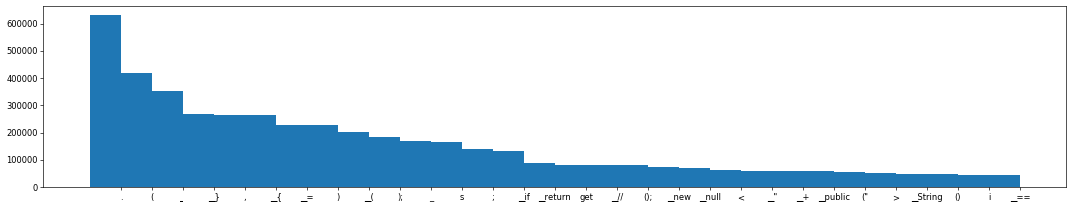

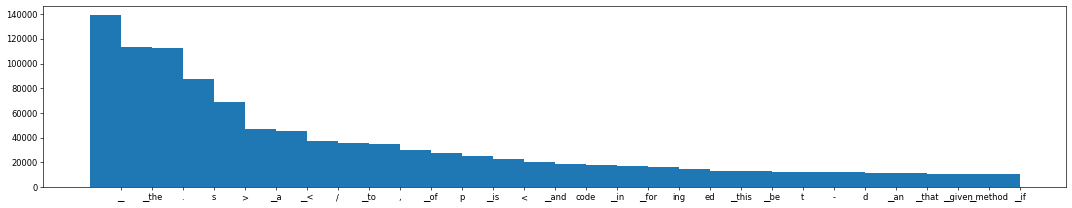

In [0]:
#collapse_show
def plot_counts(counts, top_k = 30):
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

plot_counts(code_cnt, top_k = 30)
plot_counts(comment_cnt, top_k = 30)

Plotting your frequencies as a bar chart you start to see a nice picture of your data. Not that suprising, but the most common token happens to be the period and some other common syntactical tokens like curly braces and also key words like *if* and *return*.

3.4662519750610943 3.0 2.6490695431339177


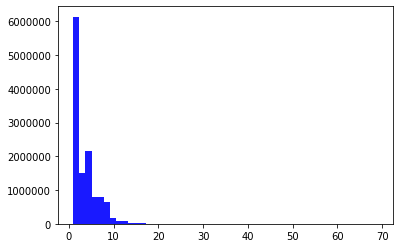

18.54957629991187 10 50.99032748692644


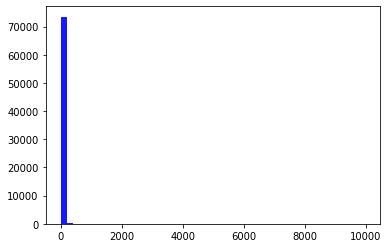

3.57512896650546 3.0 2.605938655784157


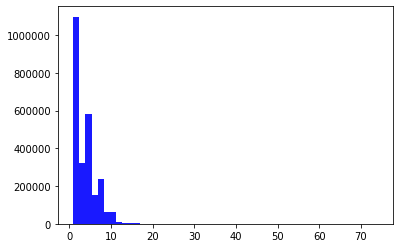

In [0]:
#collapse_show
def plot_hist(lens, n_bins = 50):
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    plt.show()

print(mean(code_lens), median(code_lens), stdev(code_lens))
plot_hist(code_lens)
print(mean(locs), median(locs), stdev(locs))
plot_hist(locs)
print(mean(comment_lens), median(comment_lens), stdev(comment_lens))
plot_hist(comment_lens)

As you can see, there are HTML elements left with < and > occurring quite often in your comments dataset that may make it harder for your model to learn to generate the comments that contain those elements. Luckily for us, it won't really affect your models accuracy, but exploring your data like this does allow us to see how your data may be influencing your model.

**TODO For You:** Perform some further cleaning steps to remove HTML and any other cleaning you deem necessary and see how your performance changes.

## Loading the data using FastAI
Now that you have the data processed and cleaned you need a way to get it into the format that FastAI uses. To do that you will use some code from Rachel Thomas' awesome [course on NLP](https://github.com/fastai/course-nlp/blob/master/7-seq2seq-translation.ipynb), which allows us to create a Sequence to Sequence (since you are going from the sequence of code to the sequence of the code's docstring) DataBunch (this is just the format FastAI uses for managing loading the data into memory for training and evaluating).

In [0]:
#collapse_show
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i, :len(s[0])],res_y[i, :len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x, res_y

class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path='.', bs=32, val_bs=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device=None, no_check=False, backwards=False, **dl_kwargs):
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

Here is where you are telling FastAI to use your trained BPE models for tokenizing your data. FastAI's tokenizers will also do some additional processing of your text such as lower casing all words, removing repetitions, etc. You can find a full list of the processing FastAI uses [here](https://docs.fast.ai/text.transform.html#Tokenizer).

In [0]:
method_processor = SPProcessor(
    sp_model = path / (method_tokenizer + ".model"),
    sp_vocab = path / (method_tokenizer + ".vocab"),
    include_eos = True)
comment_processor = SPProcessor(
    sp_model = path / (comment_tokenizer + ".model"),
    sp_vocab = path / (comment_tokenizer + ".vocab"),
    include_eos = True)

Now that you have your BPE model you will generate the DataBunches suitable for your task, which will be the Seq2Seq DataBunch. You will also filter out sequences that your too long so that you can fit everything onto a Google Colab GPU and to not have your training take too long.

In [0]:
#collapse_show
def gen_dbs(df_trn, df_val, df_tst, method_processor, comment_processor, bs = 96, max_seq = 128):
    is_valid = [False] * len(df_trn) + [True] * len(df_val)
    df_merged = pd.concat([df_trn, df_val])
    df_merged = pd.DataFrame(zip(df_merged["code"].to_list(), df_merged["docstring"].to_list(), is_valid),
                                columns = ["code", "docstring", "valid"]
    )
                             
    db_trn = (Seq2SeqTextList
              .from_df(df_merged, path = path, cols='code', processor = method_processor)
              .split_from_df(col='valid')
              .label_from_df(cols='docstring', label_cls=TextList, processor = comment_processor)
              .filter_by_func(lambda x, y: len(x) > max_seq or len(y) > max_seq)
              .databunch(bs = bs))
    
    db_tst = (Seq2SeqTextList
              .from_df(df_tst, path = path, cols='code', processor = method_processor)
              .split_by_rand_pct(valid_pct = 0.01)
              .label_from_df(cols='docstring', label_cls=TextList, processor = comment_processor)
              .filter_by_func(lambda x, y: len(x) > max_seq or len(y) > max_seq)
              .databunch(bs = 16))
    
    return db_trn, db_tst

db_trn, db_tst = gen_dbs(df_trn, df_val, df_tst, method_processor, comment_processor, bs = 96, max_seq = 128)
db_trn.show_batch()

text,target
"▁ xx b os ▁boolean ▁res er ve ( int ▁column , ▁int ▁size ) ▁{ ▁if ▁( ( column ▁< ▁0) ▁|| ▁( ( column ▁+ ▁size ) ▁> ▁columns )) ▁throw ▁new ▁index out of bound s exception ("" res er ve ▁- ▁ inc or rec t ▁column ▁/ ▁size ""); ▁for ( int ▁i = column ; ▁i ▁< ▁column ▁+ ▁size ; ▁i ++) ▁{",▁ xx b os ▁ xx ma j ▁re s er ve s ▁a ▁< code > ce ll < ▁/ ▁ xx up ▁code > ▁in ▁the ▁< code > ro w < ▁/ ▁ xx up ▁code > . ▁ xx e os
"▁ xx b os ▁@ help ( ▁ help ▁= ▁"" get ▁all ▁the ▁ virtual network function descriptor ▁ xx m a j ▁dependency ▁of ▁a ▁network service descriptor ▁with ▁specific ▁id "" ▁) ▁public ▁list < v n f d ep end en cy > ▁get v n f dependencies ( final ▁ xx m a j ▁string ▁id ns d ) ▁throws ▁s d k exception ▁{",▁ xx b os ▁ xx ma j ▁return ▁a ▁ xx ma j ▁list ▁with ▁all ▁the ▁v n f de p end en c ies ▁that ▁are ▁contain ed ▁in ▁a ▁specific ▁network service descriptor . ▁ xx e os
"▁ xx b os ▁@ override ▁public ▁void ▁delete as set and attachment s ( final ▁ xx m a j ▁string ▁as set id ) ▁throws ▁ io exception , ▁request failure exception ▁{ ▁ xx m a j ▁as set ▁as s ▁= ▁get un v er ified as set ( as set id ); ▁list < attachment > ▁attachment s ▁= ▁as s . get attachment s",▁ xx b os ▁ xx ma j ▁this ▁will ▁delete ▁an ▁asset ▁and ▁all ▁its ▁attachments ▁ xx e os
"▁ xx b os ▁public ▁list < character book mark fold er s response > ▁get character s character id book mark s fold er s ( integer ▁character id , ▁ xx m a j ▁string ▁data source , ▁ xx m a j ▁string ▁if n one match , ▁ xx m a j ▁ integer ▁page , ▁ xx m a j ▁string ▁token ) ▁throws ▁api",▁ xx b os ▁ xx ma j ▁list ▁ bookmark ▁folders ▁a ▁list ▁of ▁your ▁character & ' s ▁personal ▁ bookmark ▁folders ▁--- ▁ xx ma j ▁this ▁route ▁is ▁cached ▁for ▁up ▁to ▁36 00 ▁seconds ▁ xx up ▁ s so ▁ xx ma j ▁scope : ▁ esi - bookmark s . read _ character _ bookmark s . v 1 ▁ xx e os
"▁ xx b os ▁@ de pre c ated ▁protected ▁final ▁map < db id , ▁k n n list > ▁batch n n ( n ▁node , ▁db id s ▁ids , ▁int ▁k max ) ▁{ ▁map < db id , ▁k n n list > ▁res ▁= ▁new ▁hash map <>( id s . size ()); ▁for ( db id iter ▁iter ▁= ▁ids . iter ();",▁ xx b os ▁ xx ma j ▁perform s ▁a ▁batch ▁k - ne a rest ▁neighbor ▁query ▁for ▁a ▁list ▁of ▁query ▁objects . ▁ xx e os


In [0]:
#hide
db_trn.save("method_commenter_db_trn.pkl")
db_tst.save("method_commenter_db_tst.pkl")

In [0]:
#collapse_show
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x,y[:,:-1]], y[:,1:]

# Add the necessary shift transformation for training your Transformer model
db_trn.add_tfm(shift_tfm)
db_tst.add_tfm(shift_tfm)

In [0]:
#hide
# Run if you already have generated and saved some data
# db_trn = load_data(path, 'method_commenter_db_trn.pkl', bs = 96)
# db_tst = load_data(path, 'method_commenter_db_tst.pkl', bs = 16)
# db_trn.add_tfm(shift_tfm)
# db_tst.add_tfm(shift_tfm)

# Defining your model

In this example, you will be using the Transformer architecture that was developed by [Vaswani et. al.](https://arxiv.org/abs/1706.03762). If you want a better understanding of this model, I highly suggest [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html#applications-of-attention-in-our-model) blog post and the [NLP course](https://www.youtube.com/playlist?list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9) by Rachel Thomas, which this model code is copied from.

In [0]:
#collapse
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt,self.k_wgt,self.v_wgt = [nn.Linear(
            d_model, n_heads * d_head, bias=bias) for o in range(3)]
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(p),nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q, kv, mask=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))
    
    def create_attn_mat(self, x, layer, bs):
        return layer(x).view(bs, x.size(1), self.n_heads, self.d_head
                            ).permute(0, 2, 1, 3)
    
    def _apply_attention(self, q, kv, mask=None):
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = map(lambda o: self.create_attn_mat(*o,bs),
                       zip((q,kv,kv),(self.q_wgt,self.k_wgt,self.v_wgt)))
        attn_score = wq @ wk.transpose(2,3)
        if self.scale: attn_score /= math.sqrt(self.d_head)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = attn_prob @ wv
        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)

def get_output_mask(inp, pad_idx=1):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].byte()

class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, mask=None): return self.ff(self.mha(x, x, mask=mask))

class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_out=None): return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

In [0]:
#collapse_show
class Transformer(Module):
    def __init__(self, inp_vsz, out_vsz, n_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1):
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_out = get_output_mask(out, self.pad_idx)
        enc,out = self.enc_emb(inp),self.dec_emb(out)
        enc = compose(self.encoder)(enc)
        out = compose(self.decoder)(out, enc, mask_out)
        return self.out(out)

To evaluate your model you will be using the commonly used BLEU score, which is a measure for determining how closely your model's generated comment is to the real comment of a method. (This code is also copied from the NLP tutorial from Rachel Thomas)

In [0]:
#collapse
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

In [0]:
n_x_vocab, n_y_vocab = len(db_trn.train_ds.x.vocab.itos), len(db_trn.train_ds.y.vocab.itos)

model = Transformer(n_x_vocab, n_y_vocab, d_model=256)
learn = Learner(db_trn, model, metrics=[accuracy, CorpusBLEU(n_y_vocab)], loss_func = CrossEntropyFlat())

Now you are going to use the awesome Learning Rate finder provided by FastAI, which is based on the awesome paper from Leslie N. Smith ["Cyclical Learning Rates for Training Neural Networks"](https://arxiv.org/abs/1506.01186). This way you don't have to do a bunch of hyperparameter searching to find the perfect fit.

epoch,train_loss,valid_loss,accuracy,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 1.74E-02


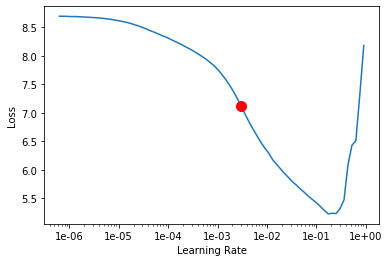

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

It is common to pick a point a bit before the suggested point.

In [0]:
max_lr = 5e-4

**DRUM ROLL PLEASE!!!!!** You are now going to finally start training your model! Specifically for 8 epochs because that was what was in the original code in the NLP course and it also happened to work the best during my training. However, you are also implementing a few call backs, namely automatically saving the best performing model, early stopping, and showing the training and validation loss graph. Since you are using early stopping, feel free to try out a higher epoch number and the training will stop once it starts not improving.

In [0]:
def train_model(learn, epochs, model_name, max_lr = 5e-4):
    """Trains a model using save model, early stopping, and show graph call backs."""
    callback_fns = [
        callbacks.SaveModelCallback(
            learn, every='improvement',
            monitor='valid_loss', name=f'{model_name}_save_model'
        ),
        callbacks.EarlyStoppingCallback(
            learn, monitor='valid_loss', min_delta = 0.01,
            patience = 3
        ),
        ShowGraph(learn)
    ]
    
    learn.fit_one_cycle(epochs, max_lr, div_factor=5, callbacks = callback_fns)

In [0]:
epochs = 8
model_name = 'comment_gen'

Training on Google Colab can take anywhere from ~20 to 60 minutes depending on the type of GPU they give you. So, relax, get an IV caffeine drip going, and let your model cook in peace :).

epoch,train_loss,valid_loss,accuracy,bleu,time
0,1.182219,1.133453,0.828182,0.791774,06:46
1,0.920205,0.954264,0.841556,0.799681,06:47
2,0.812330,0.875513,0.849487,0.804000,06:44
3,0.752023,0.828835,0.853668,0.807183,06:45
4,0.679716,0.794862,0.856593,0.809325,06:43
5,0.653454,0.777795,0.859418,0.811010,06:42
6,0.611860,0.770059,0.860419,0.812164,06:49
7,0.605370,0.769881,0.860601,0.812119,06:45


Better model found at epoch 0 with valid_loss value: 1.133453130722046.


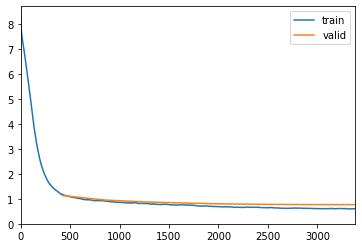

Better model found at epoch 1 with valid_loss value: 0.9542644023895264.
Better model found at epoch 2 with valid_loss value: 0.8755126595497131.
Better model found at epoch 3 with valid_loss value: 0.8288350701332092.
Better model found at epoch 4 with valid_loss value: 0.7948615550994873.
Better model found at epoch 5 with valid_loss value: 0.7777946591377258.
Better model found at epoch 6 with valid_loss value: 0.7700592279434204.
Better model found at epoch 7 with valid_loss value: 0.7698812484741211.


In [0]:
train_model(learn, epochs, model_name, max_lr = max_lr)

# Evaluate your model

Let us now evaluated your trained model on some of your validation set so see how well your model is generating comments.

In [0]:
#collapse_show
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)
            for x,y,z in zip(xb[0],xb[1],out):
                inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
                targets.append(learn.data.train_ds.y.reconstruct(y.cpu()))
                outputs.append(learn.data.train_ds.y.reconstruct(z.cpu().argmax(1)))
    return inputs, targets, outputs

inputs, targets, outputs = get_predictions(learn)

In [0]:
#collapse_show
def print_results(inputs, targets, outputs, method_spm, comment_spm, n = 10):
    """Just a little helper function for printing out the results from your model."""
    for i in range(n):
        print("Input:", " ".join(decode_spec_tokens(method_spm.DecodePieces(str(inputs[i]).split(" ")).split(" "))), "\n")
        print("Target:", " ".join(decode_spec_tokens(comment_spm.DecodePieces(str(targets[i]).split(" ")).split(" "))), "\n")
        print("Predicted:", " ".join(decode_spec_tokens(comment_spm.DecodePieces(str(outputs[i]).split(" ")).split(" "))), "\n")
        
print_results(inputs, targets, outputs, method_spm, comment_spm)

Input: xxbos @doesservicerequest private void putrangeinternal(final filerange range, final filerangeoperationtype operationtype, final byte[] data, final long length, final String md5, final accesscondition accesscondition, final filerequestoptions options, final operationcontext opcontext) throws storageexception { executionengine.executewithretry(this.fileserviceclient, this, putrangeimpl(range, operationtype, data, length, md5, accesscondition, options, opcontext), options.getretrypolicyfactory(), opcontext); } xxeos 

Target: xxbos Used for both uploadrange and clearrange. xxeos 

Predicted: xxbos Put to creating thes( s( xxeos 

Input: xxbos public static byte[] encodesequence(byte[]... encodedvalues) { int length = 0; for (byte[] encodedvalue : encodedvalues) { length += encodedvalue.length; } byte[] lengthencoded = encodelength(length); bytearraydataoutput out = bytestreams.newdataoutput(1 + lengthencoded.length + length); out.write(sequence_tag); out.write(lengthencoded); for 

This is great and all. However, you can see the text looks a bit off. Your model sort of starts generating some word and then switches half way through sometimes. This is because the way you are currently trying to generate tokens is using [Teacher Forcing](https://towardsdatascience.com/what-is-teacher-forcing-3da6217fed1c), which means you are giving the model the groundtruth for what it should have produced even if it did not. This is very helpful during training, however, it expects to have both the x and y of an input. In a real world setting, you aren't going to be given the y, obviously! 

Therefore, I found a hacky way of bypassing this need for the y so that it is no longer needed. This involves using an empty array that fakes being the y, but has only ones and is updated everytime the model makes a prediction and is then fed back into the model so that is knows what it has generated before.

**Heads Up** The way I coded this is extremely inefficient and so running it will take a long time to generate predictions. Therefore I recommend only generating a few comments (I set it up to only do 10).

**TODO For You:** Come up with a more efficient solution that performs similarly to the Teacher Forcing approach of the above code.

P.S.

For other [language learners](https://docs.fast.ai/text.learner.html#LanguageLearner.predict) provided by FastAI, you can simply use the `predict` function and pass some text and ask for the model to predict the next set of tokens. However, I have been unsuccessful in implementing this `predict` function for Sequence to Sequence models. So, another **TODO For You** is to see if you can implement a `predict` function for Sequence to Sequence models so that you can easily generate comments for methods that you just pass to the function!

If you do figure out a way to do this, I would be extremely interested! So, feel free to leave a comment about it.

In [0]:
#collapse_show
def get_preds(learn, db_tst, max_seq = 128, n = 10):
    learn.model.eval()
    inpts, trgts, preds = [], [], []
    for i, (xb,yb) in enumerate(progress_bar(db_tst.dl(DatasetType.Train))):
        if i >= n: break
        res = torch.zeros(len(xb[0]), max_seq, device = torch.device('cuda')).long() + 1
        for i in range(max_seq - 1):
            outs = learn.model(xb[0], res)
            for j, out in enumerate(outs):
                res[j][i + 1] =  out.argmax(1)[i]
        for x, y, z in zip(xb[0], yb, res):
            inpts.append(str(learn.data.train_ds.x.reconstruct(x.cpu())))
            trgts.append(str(db_tst.train_ds.y.reconstruct(y.cpu())))
            preds.append(str(learn.data.train_ds.y.reconstruct(z.cpu())))
    return inpts, trgts, preds

inputs, targets, outputs = get_preds(learn, db_tst)
print_results(inputs, targets, outputs, method_spm, comment_spm)

Input: xxbos protected String parseunquotedstringcontent() { final int startndx = ndx; while (true) { final char c = input[ndx]; if (c <= ' ' || charutil.equalsone(c, UNQUOTED_DELIMETERS)) { final int currentndx = ndx; / / done skipwhitespaces(); return new String(input, startndx, currentndx - startndx); } ndx++; } } xxeos 

Target: xxbos Parses un-quoted string content. xxeos 

Predicted: xxbos Parses the text from the HTML text. xxeos 

Input: xxbos private static void checkfilecopy(final File srcfile, final File destfile) throws ioexception { checkexists(srcfile); checkisfile(srcfile); if (equals(srcfile, destfile)) { throw new ioexception("files '" + srcfile + "' and '" + destfile + "' are equal"); } File destparent = destfile.getparentfile(); if (destparent != null && !destparent.exists()) { checkcreatedirectory(destparent); } } xxeos 

Target: xxbos Checks that file copy can occur. xxeos 

Predicted: xxbos Checks if the file is a file. xxeos 

Input: xxbos long analyze() { Arc a;

Not too shabby if I do say so myself! It seems to actually be learning about what a comment is supposed to have in it for documenting what the method is doing. Of course there are a lot of tweaks you could do such as adding the ability to generate inline comments instead of just method level, using more data, using different sampling schemes for generating the comments such as [top-k or nucleus](https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277), and any other awesome things you could think of! And if you do feel free to leave a comment about your adventure.

**Tip:**
I have done a lot of fiddling to get this to work, however, most of my models ended up overfitting. The way I fixed this issue was just being more careful in how I clean the data and also increase the data size. I know this seems simple, but it is quite effective.

# Conclusion
In this tutorial, you created an Automatic Code Comment Generator! You learned about how to clean, explore, and process data and how to use the awesome Pytorch and FastAI to define and train the awesome Transformer architecture. The use of Deep Learning in the field of Software Engineering is what I am studying for my Ph.D., so I hope I have inspired you to think about some other ways you could use Deep Learning to help Software Engineering!

I hope you enjoyed this tutorial and look out for future blog posts from me about all kinds of topics as I have announced a challenge for myself for learning new things this year!

> twitter: https://twitter.com/ncooper57/status/1235408134904086529?s=20